# <center>Flight delay prediction in JFK airport using machine learning classifiers</center>

The main goal of this notebook is to predict the delays of flights departing from JFK (New York) airport. The delay (in minutes) of every flight will be transformed into a binary target to separate delayed from non-delayed flights, resulting in a supervised classification problem. To assess whether a flight will be delayed or not, several machine learning classifiers will be used. The results will be compared and the best classifier will be chosen to improve its performance by hyperparameter tuning.

The dataset has been obtained from [Kaggle](https://www.kaggle.com/datasets/deepankurk/flight-take-off-data-jfk-airport) and contains the details of flights taking off from JFK airport between November 2019 and January 2020. The coordinates of the destination airports (longitude and latitude) are missing, so they were extracted [from another dataset](https://www.kaggle.com/datasets/usdot/flight-delays?select=airports.csv) in order to do some geographical plots.

The project is divided in 4 parts:
1. An Exploratory Data Analysis (EDA) to summarize and visualize the main charcteristics of the dataset.
2. Compare several classification algorithms (using default parameters) and test different techniques for solving the imbalanced nature of the data (e. g. SMOTE oversampling).
3. Select the best classifying algorithm and improve it by performing hyperparameter optimization.
4. Create a dashboard using [Streamlit](https://streamlit.io/) in order to display the data in a fancy and interactive way and deploy this app in [Heroku](https://www.heroku.com/).

The dashboard can be accessed here: [https://jfkdepartures.herokuapp.com/](https://jfkdepartures.herokuapp.com/)<br>
I hope you like it! 😊

In [4]:
# IMPORT ALL THE MODULES USED IN THIS NOTEBOOK
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from colour import Color
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
pd.set_option('display.max_columns', None)

## Exploratory Data Analysis (EDA)

The dataset provides JFK departures information between Nov 2019 - Jan 2020

In [6]:
df = pd.read_csv("./JFK_dep_data.csv")
df

MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER TAIL_NUM DEST  \
0         11             1            5                B6   N828JB  CHS   
1         11             1            5                B6   N992JB  LAX   
2         11             1            5                B6   N959JB  FLL   
3         11             1            5                B6   N999JQ  MCO   
4         11             1            5                DL   N880DN  ATL   
...      ...           ...          ...               ...      ...  ...   
28815      1            31            5                B6   N216JB  ORH   
28816      1            31            5                AA   N104NN  BOS   
28817      1            31            5                AS   N581AS  SEA   
28818      1            31            5                B6   N957JB  SJU   
28819      1            31            5                B6   N958JB  BQN   

       DEP_DELAY  CRS_ELAPSED_TIME  DISTANCE  CRS_DEP_M  DEP_TIME_M  \
0             -1               124       636        324         323   
1             -7               371      2475        340         333   
2             40               181      1069        301         341   
3             -2               168       944        345         343   
4             -4               139       760        360         356   
...          ...               ...       ...        ...         ...   
28815          2                57       150       1370        1372   
28816          2                75       187       1390        1392   
28817        283               392      2422       1125        1408   
28818          5               224      1598       1417        1422   
28819         -1               225      1576       1439        1438   

       CRS_ARR_M  Temperature Dew Point  Humidity Wind  Wind Speed  Wind Gust  \
0            448           48        34        58    W          25         38   
1            531           48        34        58    W          25         38   
2            482           48        34        58    W          25         38   
3            513           48        34        58    W          25         38   
4            499           46        32        58    W          24         35   
...          ...          ...       ...       ...  ...         ...        ...   
28815       1427           39        38        96    N           6          0   
28816         25           39        38        96    N           6          0   
28817       1337           39        38        96    N           6          0   
28818        261           39        38        96    N           6          0   
28819        284           39        38        96    N           6          0   

       Pressure     Condition  sch_dep  sch_arr  TAXI_OUT  
0         29.86  Fair / Windy        9       17        14  
1         29.86  Fair / Windy        9       17        15  
2         29.86  Fair / Windy        9       17        22  
3         29.86  Fair / Windy        9       17        12  
4         29.91  Fair / Windy        9       17        13  
...         ...           ...      ...      ...       ...  
28815     30.18        Cloudy       20       32        19  
28816     30.18        Cloudy       19       23        22  
28817     30.18        Cloudy       19       23        21  
28818     30.18        Cloudy       19       23        13  
28819     30.18        Cloudy       19       23        15  

[28820 rows x 23 columns]

In [7]:
# Convert column names to snake_case
def to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'\s+', '', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

df.columns = map(to_snake, df.columns)
df.columns

Index(['month', 'day_of_month', 'day_of_week', 'op_unique_carrier', 'tail_num',
       'dest', 'dep_delay', 'crs_elapsed_time', 'distance', 'crs_dep_m',
       'dep_time_m', 'crs_arr_m', 'temperature', 'dew_point', 'humidity',
       'wind', 'wind_speed', 'wind_gust', 'pressure', 'condition', 'sch_dep',
       'sch_arr', 'taxi_out'],
      dtype='object')

Plot the histograms to check the data:

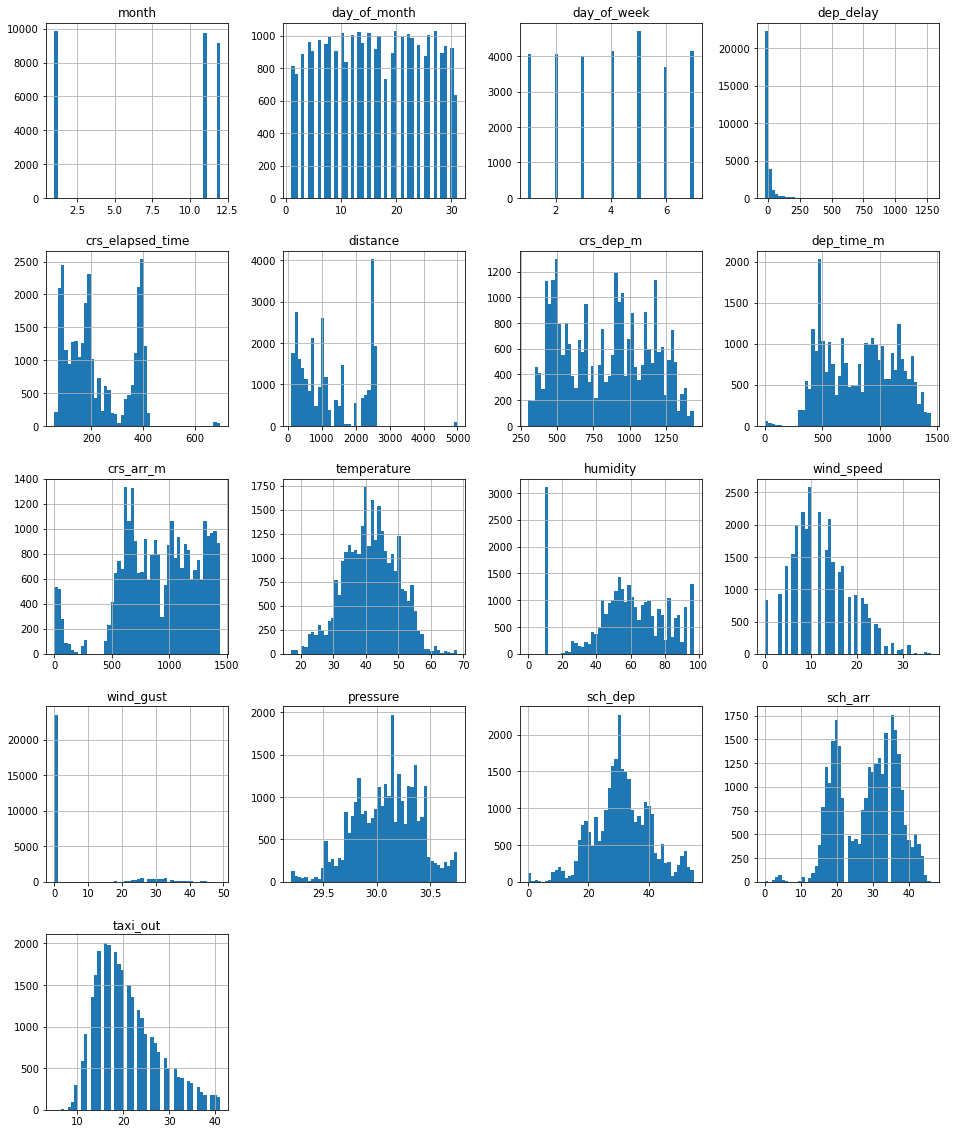

In [8]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=10, ylabelsize=10);

Check the correlation:

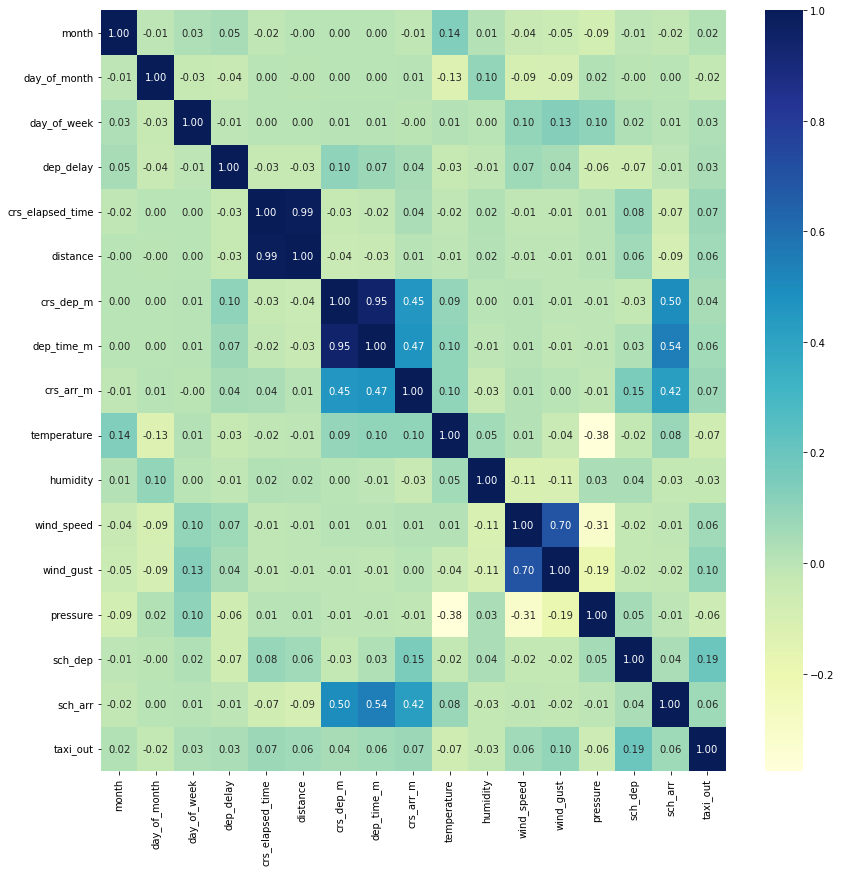

In [9]:
plt.figure(figsize = (14, 14))
sns.heatmap(df.corr(), cmap='YlGnBu', annot = True, fmt='.2f');

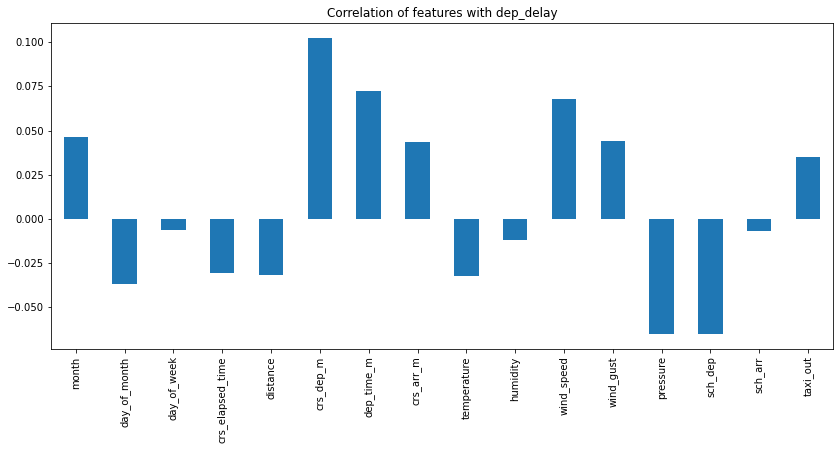

In [10]:
plt.figure(figsize = (14, 6))

df.drop(['dep_delay'], axis = 1) \
    .corrwith(df['dep_delay']) \
    .plot(kind = 'bar', title = 'Correlation of features with dep_delay');

There are no big correlations with `dep_delay` (all of them are below 0.1 -way below 1-, so they are not significant). The higher ones are:
- Departure time
- Wind speed
- Airport pressure (negative corr.)
- Scheduled departure flights (negative corr.)

In [11]:
df.dtypes

month                  int64
day_of_month           int64
day_of_week            int64
op_unique_carrier     object
tail_num              object
dest                  object
dep_delay              int64
crs_elapsed_time       int64
distance               int64
crs_dep_m              int64
dep_time_m             int64
crs_arr_m              int64
temperature            int64
dew_point             object
humidity               int64
wind                  object
wind_speed             int64
wind_gust              int64
pressure             float64
condition             object
sch_dep                int64
sch_arr                int64
taxi_out               int64
dtype: object

Tranform `dew_point` into an integer column:

In [12]:
df['dew_point'] = df['dew_point'].astype('int64')

The attribute description for the dataset is the following:

| Attribute | Description | Type |
| :- | :- | :-: |
| month | Month of the year (1-12) | int64
| day_of_month | Day of the month (1-31) | int64
| day_of_week | Day of the week (1-7) | int64
| op_unique_carrier | Airline code (9 total)| object
| tail_num | Aircraft registration (plate number) (2092 total) | object
| dest | Destination airport IATA code (3 letters) (65 total) | object
| dep_delay | Departure delay with respect to scheduled time (min) | int64
| crs_elapsed_time | Elapsed time of flight (from take-off to landing) (min) | int64
| distance | Flight distance (miles) | int64
| crs_dep_m | Scheduled departure time (min of the day) | int64
| dep_time_m | Actual departure time (min of the day) | int64
| crs_arr_m | Scheduled arrival time (min of the day) | int64
| temperature | Airport temperature (ºF) | int64
| dew_point | Dew point temperature (ºF) | int64
| humidity | Humidity level (0-100%) | int64
| wind | Wind direction (16 cardinal directions + CALM + VAR) (18 total) | object
| wind_speed | Wind speed (mph) | int64
| wind_gust | Wind gust (brief increase in the speed of the wind) (mph) | int64
| pressure | Atmospheric pressure (inHg) | float64
| condition | Sky condition (clouds, rain, fog, snow, etc.) (25 total) | object
| sch_dep | Number of flights scheduled for departure | int64
| sch_arr | Number of flights scheduled for arrival | int64
| taxi_out | Taxi out time (min) | int64

Display the number of NaN rows:

In [13]:
df.isna().sum()

month                0
day_of_month         0
day_of_week          0
op_unique_carrier    0
tail_num             0
dest                 0
dep_delay            0
crs_elapsed_time     0
distance             0
crs_dep_m            0
dep_time_m           0
crs_arr_m            0
temperature          0
dew_point            0
humidity             0
wind                 2
wind_speed           0
wind_gust            0
pressure             0
condition            0
sch_dep              0
sch_arr              0
taxi_out             0
dtype: int64

Only 2 flights have missing values of wind direction, so we delete them:

In [14]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

month  day_of_month  day_of_week op_unique_carrier tail_num dest  \
0         11             1            5                B6   N828JB  CHS   
1         11             1            5                B6   N992JB  LAX   
2         11             1            5                B6   N959JB  FLL   
3         11             1            5                B6   N999JQ  MCO   
4         11             1            5                DL   N880DN  ATL   
...      ...           ...          ...               ...      ...  ...   
28813      1            31            5                B6   N216JB  ORH   
28814      1            31            5                AA   N104NN  BOS   
28815      1            31            5                AS   N581AS  SEA   
28816      1            31            5                B6   N957JB  SJU   
28817      1            31            5                B6   N958JB  BQN   

       dep_delay  crs_elapsed_time  distance  crs_dep_m  dep_time_m  \
0             -1               124       636        324         323   
1             -7               371      2475        340         333   
2             40               181      1069        301         341   
3             -2               168       944        345         343   
4             -4               139       760        360         356   
...          ...               ...       ...        ...         ...   
28813          2                57       150       1370        1372   
28814          2                75       187       1390        1392   
28815        283               392      2422       1125        1408   
28816          5               224      1598       1417        1422   
28817         -1               225      1576       1439        1438   

       crs_arr_m  temperature  dew_point  humidity wind  wind_speed  \
0            448           48         34        58    W          25   
1            531           48         34        58    W          25   
2            482           48         34        58    W          25   
3            513           48         34        58    W          25   
4            499           46         32        58    W          24   
...          ...          ...        ...       ...  ...         ...   
28813       1427           39         38        96    N           6   
28814         25           39         38        96    N           6   
28815       1337           39         38        96    N           6   
28816        261           39         38        96    N           6   
28817        284           39         38        96    N           6   

       wind_gust  pressure     condition  sch_dep  sch_arr  taxi_out  
0             38     29.86  Fair / Windy        9       17        14  
1             38     29.86  Fair / Windy        9       17        15  
2             38     29.86  Fair / Windy        9       17        22  
3             38     29.86  Fair / Windy        9       17        12  
4             35     29.91  Fair / Windy        9       17        13  
...          ...       ...           ...      ...      ...       ...  
28813          0     30.18        Cloudy       20       32        19  
28814          0     30.18        Cloudy       19       23        22  
28815          0     30.18        Cloudy       19       23        21  
28816          0     30.18        Cloudy       19       23        13  
28817          0     30.18        Cloudy       19       23        15  

[28818 rows x 23 columns]

We also drop `tail_num` column, since it doesn't provide useful information to predict delays, it's just the aircraft identifier

In [15]:
df.drop('tail_num', axis=1, inplace=True)

### An imbalanced dataset

The main goal of this classification problem is to predict whether a flight will be delayed or not based on the the features values. Thus, the prediction of flight delay is a binary classification problem. In the target column, a value of 0 should represent flights that are not delayed and 1 the ones that are delayed. Currently, the dataset doesn't contain this kind of binary column.<br>Note that `dep_delay` column shows the delay in minutes -it can also be negative if the airplane departed before the Estimated Time of Departure (ETD)-:

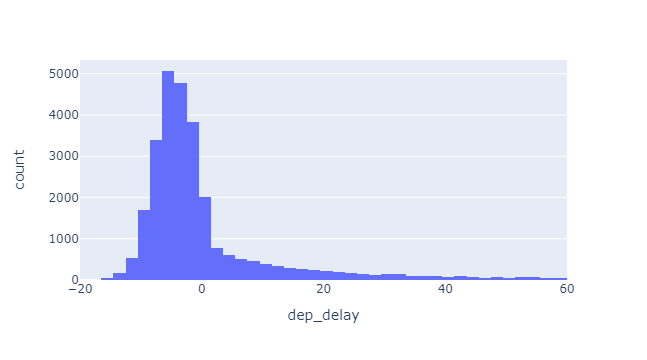

In [16]:
fig = px.histogram(df, x='dep_delay', range_x=[-20,60])
fig.show()

The big majority of flights departed on time, but the histogram shows a great dispersion for the ones that were delayed:

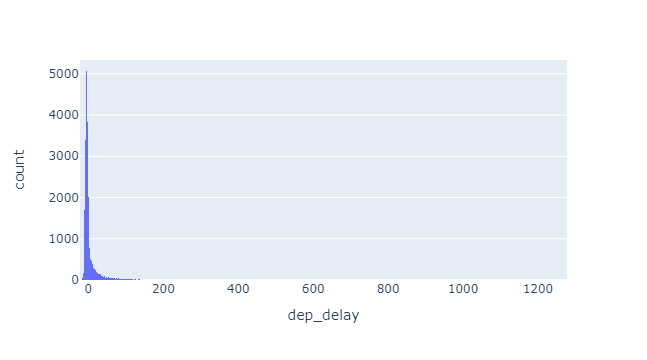

In [17]:
fig = px.histogram(df, x='dep_delay')
fig.show()

In order to convert `dep_delay` into a binary target column, a *threshold* or *cutoff value* must be set to separate delayed from non-delayed flights. The Federal Aviation Administration (FAA) considers a flight to be delayed when it is **15 minutes** later than its scheduled time (see [OPSNET Delay Cause](https://aspm.faa.gov/aspmhelp/index/Types_of_Delay.html)).<br>
However, using this criterion, the dataset turns out to be strongly imbalanced:

In [18]:
dep_delay = df['dep_delay'].to_numpy()

In [19]:
print(f"{len(df[dep_delay < 15])/len(df)*100:.2f}% of the flights have no departure delay")
print(f"{len(df[dep_delay >= 15])/len(df)*100:.2f}% of the flights are delayed")

86.05% of the flights have no departure delay
13.95% of the flights are delayed


Since the distribution of the two classes is very different, the classification algorithms tend to get biased towards the majority values present and don’t perform well on the minority values. This issue will be addressed later on by using different data-balancing techniques.

By looking at the descriptive statistics of the dataframe, it can be seen that the mean value of the delay is $\mu = 6.37$ minutes with a standard deviation of $\sigma = 38.74$ minutes. The value of $\mu$ could also be a good threshold value, but we will use the 15 minutes considered by the FAA.

In [20]:
df.describe()

month  day_of_month   day_of_week     dep_delay  \
count  28818.000000  28818.000000  28818.000000  28818.000000   
mean       7.893955     16.020890      4.008953      6.373239   
std        4.991779      8.750448      1.985299     38.735195   
min        1.000000      1.000000      1.000000    -22.000000   
25%        1.000000      8.000000      2.000000     -6.000000   
50%       11.000000     16.000000      4.000000     -3.000000   
75%       12.000000     24.000000      6.000000      2.000000   
max       12.000000     31.000000      7.000000   1276.000000   

       crs_elapsed_time      distance     crs_dep_m    dep_time_m  \
count      28818.000000  28818.000000  28818.000000  28818.000000   
mean         225.294399   1267.787494    830.970470    828.898987   
std          119.483432    889.354031    299.381938    305.844666   
min           57.000000     94.000000    301.000000      1.000000   
25%          124.000000    483.000000    545.000000    542.000000   
50%          188.000000   1029.000000    856.000000    854.000000   
75%          365.000000   2248.000000   1095.000000   1097.000000   
max          697.000000   4983.000000   1439.000000   1440.000000   

          crs_arr_m   temperature     dew_point      humidity    wind_speed  \
count  28818.000000  28818.000000  28818.000000  28818.000000  28818.000000   
mean     910.886980     41.491047     30.422236     57.732806     12.368485   
std      345.370574      8.042493     12.313335     23.469480      6.258667   
min        1.000000     17.000000     -3.000000      0.000000      0.000000   
25%      667.000000     36.000000     23.000000     46.000000      8.000000   
50%      918.000000     42.000000     31.000000     59.000000     12.000000   
75%     1192.750000     47.000000     39.000000     74.000000     16.000000   
max     1439.000000     68.000000     67.000000     97.000000     36.000000   

          wind_gust      pressure       sch_dep       sch_arr      taxi_out  
count  28818.000000  28818.000000  28818.000000  28818.000000  28818.000000  
mean       5.535707     30.092410     31.091956     28.431813     20.857207  
std       11.886780      0.296158      9.510317      8.263242      6.850197  
min        0.000000     29.200000      0.000000      0.000000      5.000000  
25%        0.000000     29.880000     26.000000     21.000000     16.000000  
50%        0.000000     30.110000     30.000000     30.000000     19.000000  
75%        0.000000     30.320000     37.000000     35.000000     25.000000  
max       49.000000     30.750000     55.000000     46.000000     41.000000

Note that the median value, by definition, would separate the target into two well-balanced classes, but it makes no sense to consider that a flight has delay even when it departs before the scheduled time.

In [21]:
np.median(dep_delay)

-3.0

So, we create a binary target column called `IS_DELAY`:<br>
- 0 : non-delayed flights ($<15$ min)
- 1 : delayed flights ($\ge15$ min)

In [22]:
df['is_delay'] = np.where(df['dep_delay'] >= 15, 1, 0)

In [23]:
df[['dep_delay', 'is_delay']]

dep_delay  is_delay
0             -1         0
1             -7         0
2             40         1
3             -2         0
4             -4         0
...          ...       ...
28813          2         0
28814          2         0
28815        283         1
28816          5         0
28817         -1         0

[28818 rows x 2 columns]

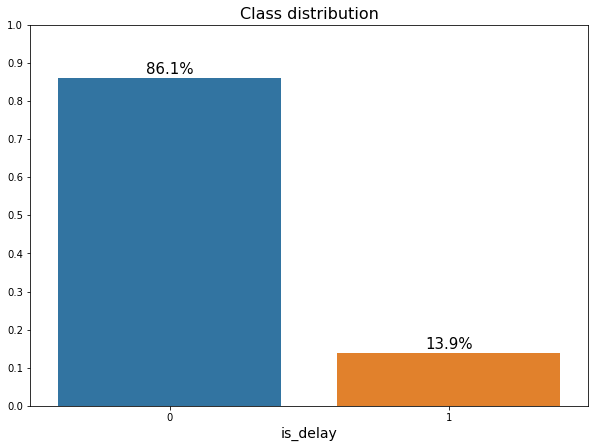

In [24]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="is_delay", y="is_delay", data=df, estimator=lambda x: len(x) / len(df))

#Anotating the graph
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
               y+height+0.01, 
               '{:.1%}'.format(height), 
               horizontalalignment='center',fontsize=15)

plt.xlabel('is_delay', fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.label.set_visible(False)
plt.title('Class distribution', fontsize=16)
plt.show()

### Getting the mean delay for each destination

In [25]:
df_grouped = df \
                .groupby('dest') \
                .agg(np.mean)['dep_delay'] \
                .sort_values(ascending=False) \
                .reset_index()
df_grouped

dest  dep_delay
0   PSE  23.358974
1   JAC  22.200000
2   ORH  16.211111
3   BWI  15.665796
4   SAT  15.331250
..  ...        ...
60  RNO   1.936170
61  HNL   1.892157
62  CHS   1.455764
63  STT   0.467742
64  OAK  -1.786885

[65 rows x 2 columns]

To plot this result on a map, we need the coordinates of every airport (longitude and latitude). This data is available in the `airports.csv` file

In [26]:
df_airports = pd.read_csv("./airports.csv")
df_airports.rename(columns = {'IATA_CODE':'dest'}, inplace=True)
df_airports

dest                              AIRPORT                            CITY  \
0    ABE  Lehigh Valley International Airport                       Allentown   
1    ABI             Abilene Regional Airport                         Abilene   
2    ABQ    Albuquerque International Sunport                     Albuquerque   
3    ABR            Aberdeen Regional Airport                        Aberdeen   
4    ABY   Southwest Georgia Regional Airport                          Albany   
..   ...                                  ...                             ...   
317  WRG                     Wrangell Airport                        Wrangell   
318  WYS               Westerly State Airport                West Yellowstone   
319  XNA  Northwest Arkansas Regional Airport  Fayetteville/Springdale/Rogers   
320  YAK                      Yakutat Airport                         Yakutat   
321  YUM           Yuma International Airport                            Yuma   

    STATE COUNTRY  LATITUDE  LONGITUDE  
0      PA     USA  40.65236  -75.44040  
1      TX     USA  32.41132  -99.68190  
2      NM     USA  35.04022 -106.60919  
3      SD     USA  45.44906  -98.42183  
4      GA     USA  31.53552  -84.19447  
..    ...     ...       ...        ...  
317    AK     USA  56.48433 -132.36982  
318    MT     USA  44.68840 -111.11764  
319    AR     USA  36.28187  -94.30681  
320    AK     USA  59.50336 -139.66023  
321    AZ     USA  32.65658 -114.60597  

[322 rows x 7 columns]

In [27]:
df_merge = pd.merge(df_grouped, df_airports, on='dest')
df_merge.columns = df_merge.columns.str.lower()
df_merge.drop(['country'], axis=1, inplace=True)
df_merge

dest  dep_delay                                          airport  \
0   PSE  23.358974                                Mercedita Airport   
1   JAC  22.200000                             Jackson Hole Airport   
2   ORH  16.211111                       Worcester Regional Airport   
3   BWI  15.665796       Baltimore-Washington International Airport   
4   SAT  15.331250                San Antonio International Airport   
..  ...        ...                                              ...   
60  RNO   1.936170                 Reno/Tahoe International Airport   
61  HNL   1.892157                   Honolulu International Airport   
62  CHS   1.455764  Charleston International Airport/Charleston AFB   
63  STT   0.467742                            Cyril E. King Airport   
64  OAK  -1.786885                    Oakland International Airport   

                city state  latitude  longitude  
0              Ponce    PR  18.00830  -66.56301  
1            Jackson    WY  43.60732 -110.73774  
2          Worcester    MA  42.26734  -71.87571  
3          Baltimore    MD  39.17540  -76.66820  
4        San Antonio    TX  29.53369  -98.46978  
..               ...   ...       ...        ...  
60              Reno    NV  39.49858 -119.76806  
61          Honolulu    HI  21.31869 -157.92241  
62        Charleston    SC  32.89865  -80.04051  
63  Charlotte Amalie    VI  18.33731  -64.97336  
64           Oakland    CA  37.72129 -122.22072  

[65 rows x 7 columns]

In the plot, we set the opacity and color of the lines between origin airport (JFK) and destination airport as a function of the mean delay of the route. This can be done by applying the following affine transformation ($x \rightarrow y$) :

$$y = (x - a)\dfrac{d-c}{b-a} + c$$

Where $x$ are the mean delay values in the range $[a,b]$ and $y$ the output color/opacity values in the range $[c,d]$.<br>
In this case, mean delay values range from $a = -1.78$ min to $b = 23.36$ min and we want the opacity values to range from $c = 0.2$ to $d = 1$ and the color values to range from $c = 0$ to $d = 255$

In [28]:
min_opacity = 0.2
max_opacity = 1
min_color = 0
max_color = 255
min_delay = df_merge['dep_delay'].min()
max_delay = df_merge['dep_delay'].max()

df_merge['opacity'] = (df_merge['dep_delay'] - min_delay)*((max_opacity - min_opacity)/(max_delay - min_delay)) + min_opacity
df_merge['color'] = (df_merge['dep_delay'] - min_delay)*((max_color - min_color)/(max_delay - min_delay)) + min_color

df_merge[['opacity', 'color']]

opacity       color
0   1.000000  255.000000
1   0.963128  243.247033
2   0.772595  182.514702
3   0.755246  176.984755
4   0.744603  173.592176
..       ...         ...
60  0.318447   37.754889
61  0.317046   37.308557
62  0.303163   32.883170
63  0.271730   22.863801
64  0.200000    0.000000

[65 rows x 2 columns]

We can also choose the minimum delay to plot (that is, mean delays below that value won't be plotted):

In [29]:
min_delay_to_plot = -2

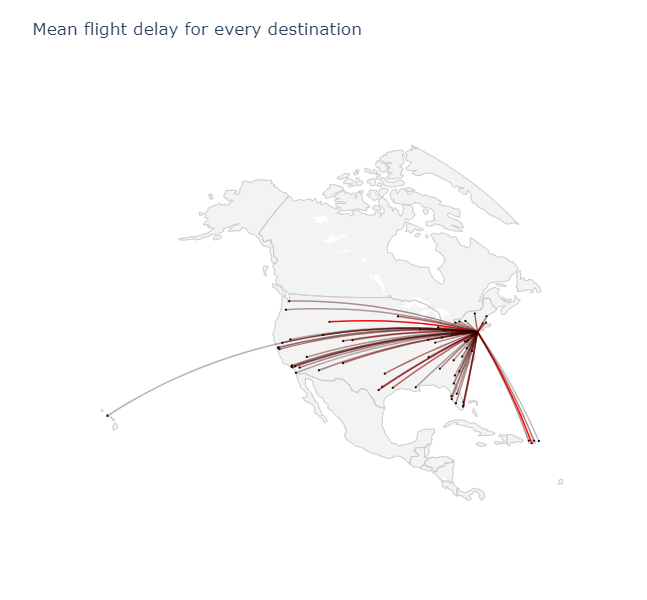

In [30]:
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_merge['longitude'],
    lat = df_merge['latitude'],
    hoverinfo = 'text',
    text = df_merge['city'] +" ("+df_merge['dest']+")",
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(0, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

jfk_lon = -73.77893
jfk_lat = 40.63975

for i in range(len(df_merge)):
    if df_merge['dep_delay'][i] > min_delay_to_plot:
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [jfk_lon, df_merge['longitude'][i]],
                lat = [jfk_lat, df_merge['latitude'][i]],
                mode = 'lines',
                line = dict(width = 1.5,
                            # color = 'rgb('+str(df_merge['color'][i])+',0,'+str(255-df_merge['color'][i])+')'),
                            color = 'rgb('+str(df_merge['color'][i])+',0,0)'),
                            # color = 'rgb(0,0,0)'),
                opacity = df_merge['opacity'][i],
                # opacity = 0.5,
                hoverinfo = 'text',
                text = df_merge['city'][i] +" ("+df_merge['dest'][i]+"), mean_delay = " + str(round(df_merge['dep_delay'][i], 2))
            )
        )

fig.update_layout(
    title_text = 'Mean flight delay for every destination',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)'
    ),
    margin=dict(l=5, r=5, t=70, b=40),
    height=600
)

fig.show()

### Airlines with more delays

We plot the percentage of delayed flights for each air-carrier:

In [31]:
df_del_airlines = (df.groupby('op_unique_carrier')['is_delay'].mean()*100).reset_index(name='delayed_percentage')
df_del_airlines

op_unique_carrier  delayed_percentage
0                9E           11.373773
1                AA           11.599444
2                AS           13.501350
3                B6           17.167292
4                DL           12.682292
5                HA            7.777778
6                MQ           16.746411
7                OO           16.720257
8                YX            9.737418

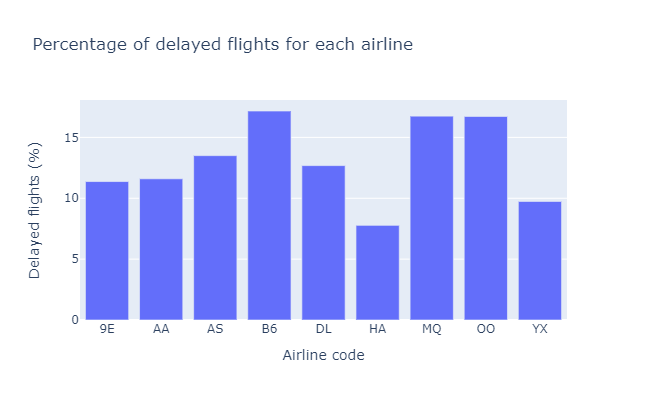

In [32]:
fig = px.bar(df_del_airlines, x='op_unique_carrier', y='delayed_percentage',
             labels = {'op_unique_carrier' : 'Airline code', 'delayed_percentage' : 'Delayed flights (%)'},
             title = 'Percentage of delayed flights for each airline',
             height = 400)
fig.show()

The company with more delays (17.17% of flights departed >15 min late) is B6 (**JetBlue Airways**).<br>
The company with less delays (7.78% of flights departed >15min late) is HA (**Hawaiian Airlines**).

### Sky condition for delayed flights

In [33]:
df_sky_cond = (df.groupby('condition')['is_delay'].mean()*100).reset_index(name='delayed_percentage')
df_sky_cond

condition  delayed_percentage
0                  Cloudy           12.179487
1          Cloudy / Windy           22.287390
2         Drizzle and Fog            0.000000
3                    Fair           13.537118
4            Fair / Windy           15.686275
5                     Fog           11.564626
6             Fog / Windy           32.142857
7              Heavy Rain           40.740741
8      Heavy Rain / Windy           16.666667
9           Light Drizzle            9.793814
10  Light Drizzle / Windy            5.555556
11    Light Freezing Rain           25.000000
12             Light Rain           18.123324
13     Light Rain / Windy           15.277778
14             Light Snow           22.368421
15     Light Snow / Windy           62.500000
16          Mostly Cloudy           12.190309
17  Mostly Cloudy / Windy           15.256588
18          Partly Cloudy           13.711437
19  Partly Cloudy / Windy           21.305842
20                   Rain           29.059829
21           Rain / Windy           16.000000
22                   Snow            0.000000
23             Wintry Mix           26.506024
24     Wintry Mix / Windy           50.000000

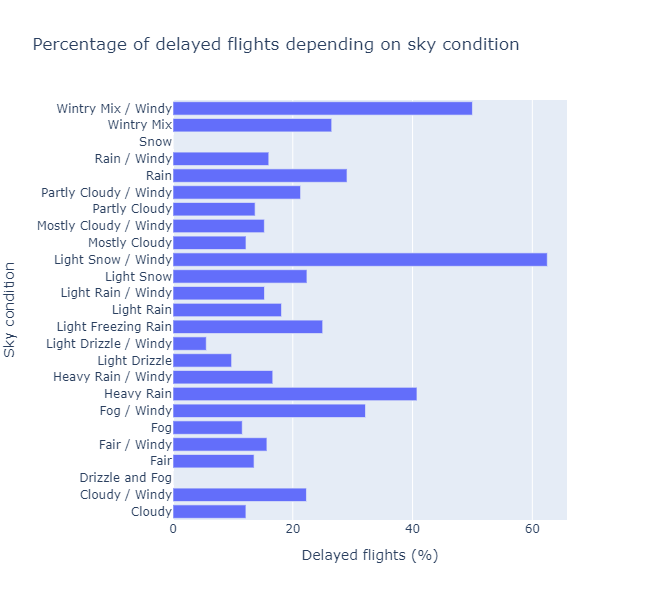

In [34]:
fig = px.bar(df_sky_cond, x='delayed_percentage', y='condition', orientation = 'h',
             labels = {'condition' : 'Sky condition', 'delayed_percentage' : 'Delayed flights (%)'},
             title = 'Percentage of delayed flights depending on sky condition',
             height = 600)
fig.show()

It can be seen that windy and rainy conditions are not beneficial for flight departures.<br>
The 62.5 % of flights in 'Light Snow / Windy' conditions were delayed, which is a considerable figure.

### Getting the most frequent destinations

In [35]:
df_dest = df.groupby('dest').size().reset_index(name='counts')
df_dest['percentage'] = df_dest['counts'] / df_dest['counts'].sum() * 100
df_dest.sort_values(by='dest', ascending=False, inplace=True)

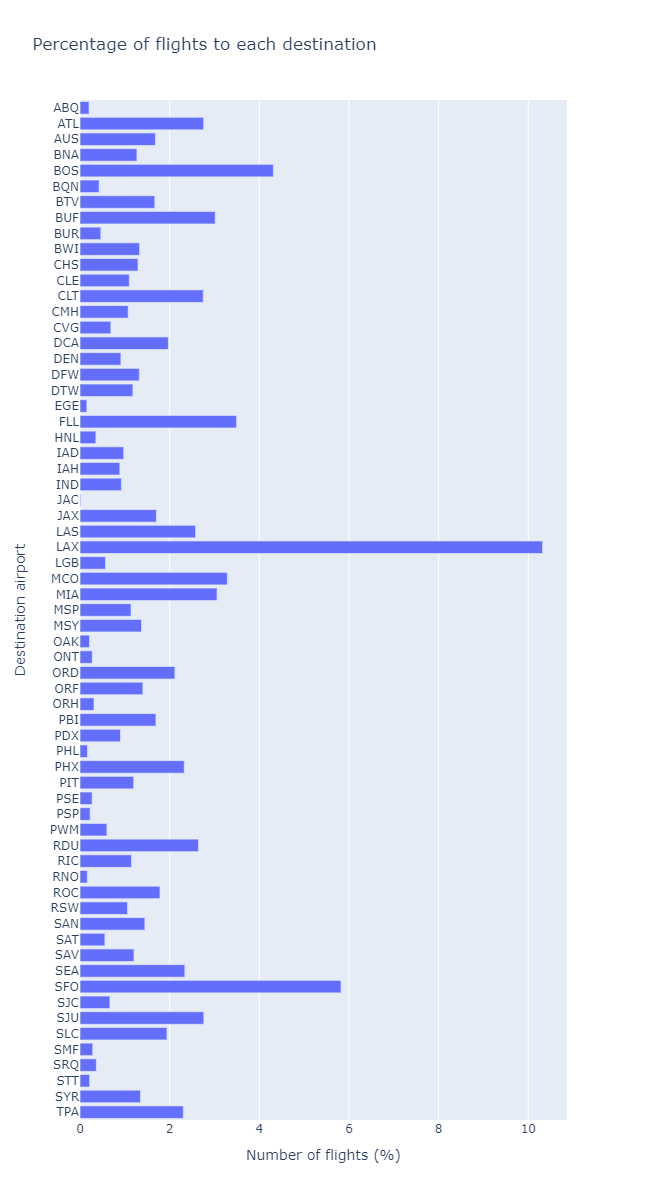

In [36]:
fig = px.bar(df_dest, x='percentage', y='dest',  orientation = 'h',
             labels = {'dest' : 'Destination airport', 'percentage' : 'Number of flights (%)'},
             title = 'Percentage of flights to each destination',
             height = 1200)
fig.show()

The two most frequent routes are:<br>
- JFK - LAX (New York - Los Angeles)
- JFK - SFO (New York - San Francisco)

## Trying the algorithms and comparing the results

#### Classification algorithms:
- k-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Decision Tree
- Random Forest
- Gaussian Naive Bayes classifier
- Logistic Regression
- Gradient Boosting classifier

#### Scoring parameters:
- Accuracy
- Precision
- Recall
- F1-Score

---

##### One Hot Encoding on categorical features (117-4 new cols.):
- Airline identifier: 9 new cols.
- Destination airport: 65 new cols.
- Sky condition: 25 new cols.
- Wind direction: 18 new cols.

In [39]:
df_enc = pd.get_dummies(df)

In [40]:
df_enc

month  day_of_month  day_of_week  dep_delay  crs_elapsed_time  \
0         11             1            5         -1               124   
1         11             1            5         -7               371   
2         11             1            5         40               181   
3         11             1            5         -2               168   
4         11             1            5         -4               139   
...      ...           ...          ...        ...               ...   
28813      1            31            5          2                57   
28814      1            31            5          2                75   
28815      1            31            5        283               392   
28816      1            31            5          5               224   
28817      1            31            5         -1               225   

       distance  crs_dep_m  dep_time_m  crs_arr_m  temperature  dew_point  \
0           636        324         323        448           48         34   
1          2475        340         333        531           48         34   
2          1069        301         341        482           48         34   
3           944        345         343        513           48         34   
4           760        360         356        499           46         32   
...         ...        ...         ...        ...          ...        ...   
28813       150       1370        1372       1427           39         38   
28814       187       1390        1392         25           39         38   
28815      2422       1125        1408       1337           39         38   
28816      1598       1417        1422        261           39         38   
28817      1576       1439        1438        284           39         38   

       humidity  wind_speed  wind_gust  pressure  sch_dep  sch_arr  taxi_out  \
0            58          25         38     29.86        9       17        14   
1            58          25         38     29.86        9       17        15   
2            58          25         38     29.86        9       17        22   
3            58          25         38     29.86        9       17        12   
4            58          24         35     29.91        9       17        13   
...         ...         ...        ...       ...      ...      ...       ...   
28813        96           6          0     30.18       20       32        19   
28814        96           6          0     30.18       19       23        22   
28815        96           6          0     30.18       19       23        21   
28816        96           6          0     30.18       19       23        13   
28817        96           6          0     30.18       19       23        15   

       is_delay  op_unique_carrier_9E  op_unique_carrier_AA  \
0             0                     0                     0   
1             0                     0                     0   
2             1                     0                     0   
3             0                     0                     0   
4             0                     0                     0   
...         ...                   ...                   ...   
28813         0                     0                     0   
28814         0                     0                     1   
28815         1                     0                     0   
28816         0                     0                     0   
28817         0                     0                     0   

       op_unique_carrier_AS  op_unique_carrier_B6  op_unique_carrier_DL  \
0                         0                     1                     0   
1                         0                     1                     0   
2                         0                     1                     0   
3                         0                     1                     0   
4                         0                     0                     1   
...                     ...                   ...

In [41]:
X = df_enc.drop(columns=['dep_delay', 'is_delay'])
y = df_enc['is_delay']

### No technique used to handle the imbalanced dataset

Split the dataset using 80% for training and 20% for testing:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Arrays for saving the scores:

In [46]:
clfs = ["KNN", "SVM", "Decision Tree", "Random Forest", "Gaussian N-B", "Logistic Regression", "Gradient Boosting"]

Arrays to store the scores:

In [47]:
acc_res = []
pre_res = []
rec_res = []
f1_res = []

We create a function to fit the model using the training set, predict the results using the test features, plot the confusion matrix and calculate the scores:

In [48]:
def get_results(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} results:")
    cm_display = ConfusionMatrixDisplay(cm).plot()
    plt.show()
    
    # Get the scores
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print the results
    print(f"- Accuracy score: {acc:.4f}")
    print(f"- Precision score: {pre:.4f}")
    print(f"- Recall score: {rec:.4f}")
    print(f"- F1 score: {f1:.4f}")
    print()
    
    return acc, pre, rec, f1

#### KNN Classifier

Let's try the function for a KNN Classifier:

KNN results:


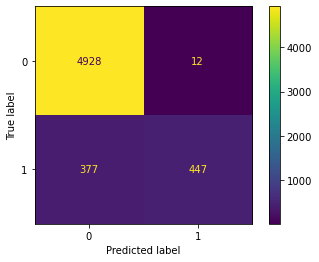

- Accuracy score: 0.9325
- Precision score: 0.9739
- Recall score: 0.5425
- F1 score: 0.6968



In [63]:
acc_knn, pre_knn, rec_knn, f1_knn = get_results("KNN", KNeighborsClassifier(), X_train, X_test, y_train, y_test)

acc_res.append(acc_knn)
pre_res.append(pre_knn)
rec_res.append(rec_knn)
f1_res.append(f1_knn)

As it can be seen, the algorithm correctly classifies 0 class (only 12 incorrect predictions from a total of 4940), but struggles to guess the correct values for delayed flights. That is, the algorithm is biased towards the predominant class.<br>
The accuracy of the model is excellent, aswell as the precision (since there are very few false positives), but the recall and the F1 score are quite poor. The model tends to misclassify the delayed flights (class 1).

#### Iterative process for the 6 remaining algorithms

Let's call `get_results` function for the remaining algorithms and compare the results:

In [64]:
models = {
            "SVM" : svm.SVC(random_state=42),
            "Decision Tree" : DecisionTreeClassifier(random_state=42),
            "Random Forest" : RandomForestClassifier(random_state=42),
            "Gaussian N-B" : GaussianNB(),
            "Logistic Regression" : LogisticRegression(random_state=42),
            "Gradient Boosting" : GradientBoostingClassifier(random_state=42)
         }

The following execution may take a while... (1 min in my case)

SVM results:


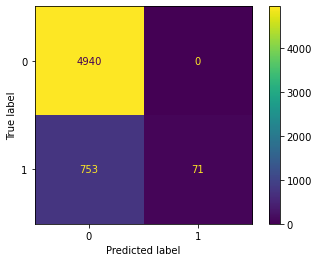

- Accuracy score: 0.8694
- Precision score: 1.0000
- Recall score: 0.0862
- F1 score: 0.1587

Decision Tree results:


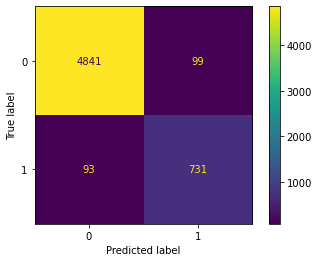

- Accuracy score: 0.9667
- Precision score: 0.8807
- Recall score: 0.8871
- F1 score: 0.8839

Random Forest results:


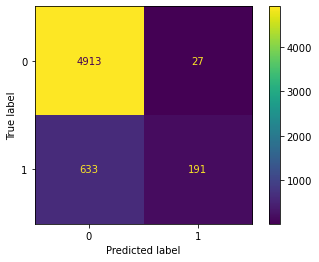

- Accuracy score: 0.8855
- Precision score: 0.8761
- Recall score: 0.2318
- F1 score: 0.3666

Gaussian N-B results:


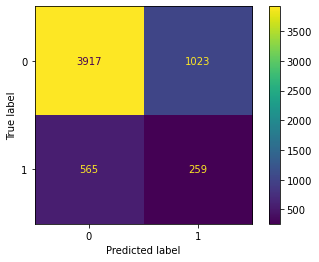

- Accuracy score: 0.7245
- Precision score: 0.2020
- Recall score: 0.3143
- F1 score: 0.2460

Logistic Regression results:


C:\Users\cmore\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



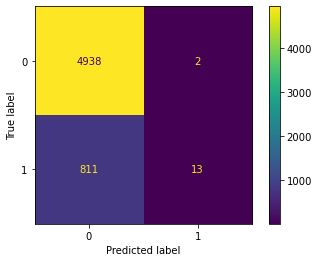

- Accuracy score: 0.8590
- Precision score: 0.8667
- Recall score: 0.0158
- F1 score: 0.0310

Gradient Boosting results:


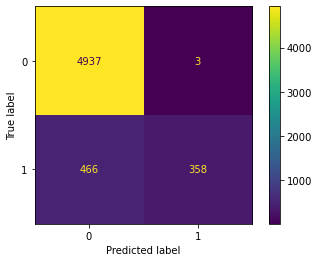

- Accuracy score: 0.9186
- Precision score: 0.9917
- Recall score: 0.4345
- F1 score: 0.6042



In [65]:
for key in models:
    acc, pre, rec, f1 = get_results(key, models[key], X_train, X_test, y_train, y_test)
    acc_res.append(acc)
    pre_res.append(pre)
    rec_res.append(rec)
    f1_res.append(f1)

Comparing the scores:

In [66]:
df_res = pd.DataFrame({'Classifiers':clfs, 'F1 Score':f1_res, 'Accuracy':acc_res, 'Precision':pre_res, 'Recall':rec_res})
df_res

Classifiers  F1 Score  Accuracy  Precision    Recall
0                  KNN  0.696804  0.932512   0.973856  0.542476
1                  SVM  0.158659  0.869362   1.000000  0.086165
2        Decision Tree  0.883918  0.966690   0.880723  0.887136
3        Random Forest  0.366603  0.885496   0.876147  0.231796
4         Gaussian N-B  0.245964  0.724497   0.202028  0.314320
5  Logistic Regression  0.030989  0.858952   0.866667  0.015777
6    Gradient Boosting  0.604219  0.918633   0.991690  0.434466

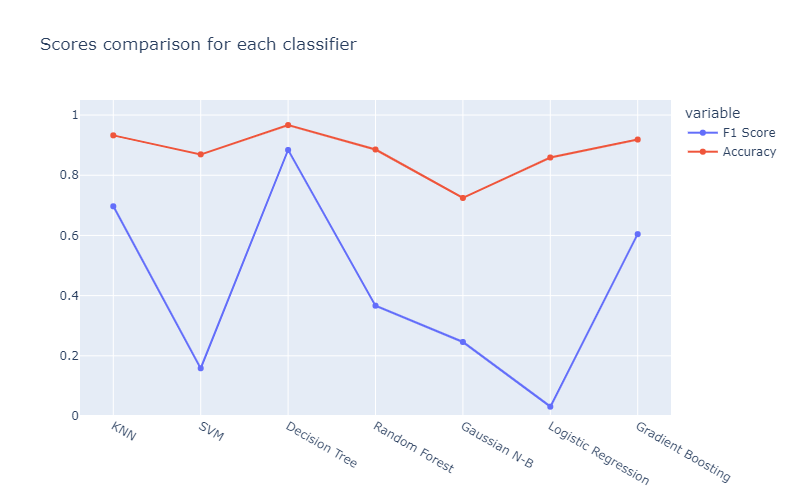

In [67]:
fig = px.line(df_res, x='Classifiers', y=['F1 Score', 'Accuracy'], markers=True,
              title="Scores comparison for each classifier",
              height=500,
              range_y=[0,1.05])

fig.update_layout(xaxis_title=None, yaxis_title=None)

fig.show()

We get mixed results, some models like KNN, Decision Tree or Gradient Boosting perform fairly well by using the default parameters of the algorithm, and others like SVM or Logistic Regression don't (Logistic Regression didn't converge). Nonetheless, the accuracy is always higher than the f1 score (in some cases there is a huge difference), which indicates the imbalanced nature of the data.

#### Repeat the experiment standardizing the features

In [72]:
X_norm = StandardScaler().fit_transform(X)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [74]:
acc_std_res = []
pre_std_res = []
rec_std_res = []
f1_std_res = []

In [75]:
models = {
            "KNN" : KNeighborsClassifier(),
            "SVM" : svm.SVC(),
            "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "Gaussian N-B" : GaussianNB(),
            "Logistic Regression" : LogisticRegression(),
            "Gradient Boosting" : GradientBoostingClassifier()
         }

The following execution may take a while... (3 min 30 s in my case)

KNN results:


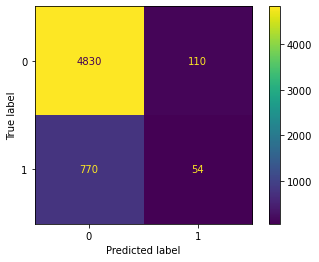

- Accuracy score: 0.8473
- Precision score: 0.3293
- Recall score: 0.0655
- F1 score: 0.1093

SVM results:


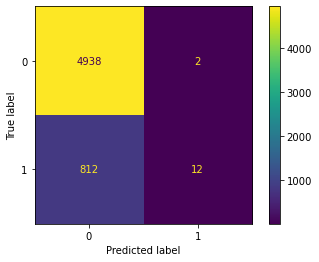

- Accuracy score: 0.8588
- Precision score: 0.8571
- Recall score: 0.0146
- F1 score: 0.0286

Decision Tree results:


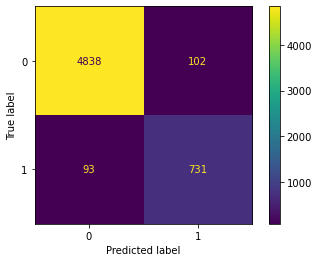

- Accuracy score: 0.9662
- Precision score: 0.8776
- Recall score: 0.8871
- F1 score: 0.8823

Random Forest results:


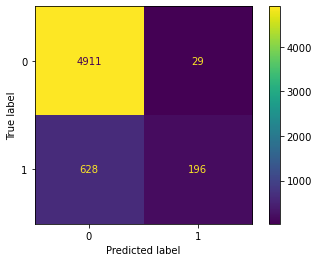

- Accuracy score: 0.8860
- Precision score: 0.8711
- Recall score: 0.2379
- F1 score: 0.3737

Gaussian N-B results:


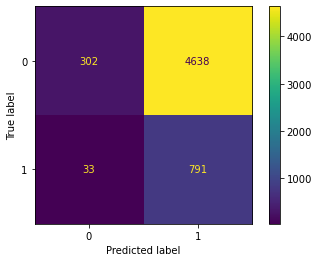

- Accuracy score: 0.1896
- Precision score: 0.1457
- Recall score: 0.9600
- F1 score: 0.2530

Logistic Regression results:


C:\Users\cmore\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



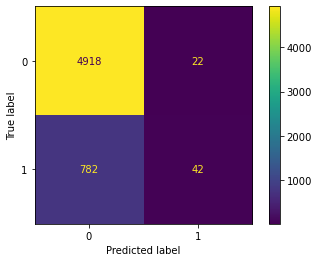

- Accuracy score: 0.8605
- Precision score: 0.6562
- Recall score: 0.0510
- F1 score: 0.0946

Gradient Boosting results:


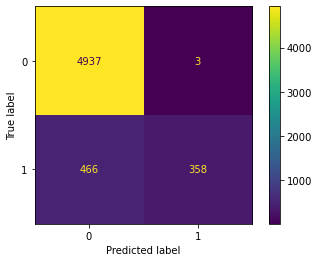

- Accuracy score: 0.9186
- Precision score: 0.9917
- Recall score: 0.4345
- F1 score: 0.6042



In [76]:
for key in models:
    acc, pre, rec, f1 = get_results(key, models[key], X_train, X_test, y_train, y_test)
    acc_std_res.append(acc)
    pre_std_res.append(pre)
    rec_std_res.append(rec)
    f1_std_res.append(f1)

In [77]:
df_f1_comp = pd.DataFrame({'Classifiers':clfs, 'Unaltered features':f1_res, 'Standardized features':f1_std_res})
df_f1_comp

Classifiers  Unaltered features  Standardized features
0                  KNN            0.696804               0.109312
1                  SVM            0.158659               0.028640
2        Decision Tree            0.883918               0.882317
3        Random Forest            0.366603               0.373689
4         Gaussian N-B            0.245964               0.252999
5  Logistic Regression            0.030989               0.094595
6    Gradient Boosting            0.604219               0.604219

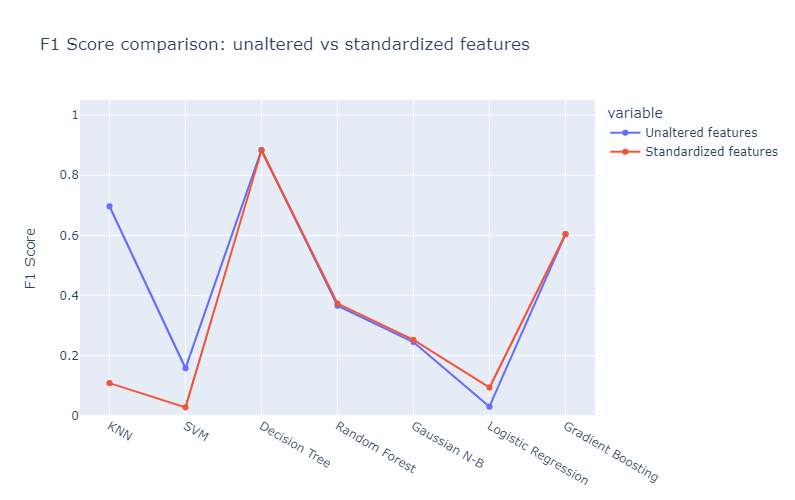

In [78]:
fig = px.line(df_f1_comp, x='Classifiers', y=['Unaltered features', 'Standardized features'], markers=True,
              title="F1 Score comparison: unaltered vs standardized features",
              height=500,
              range_y=[0,1.05])

fig.update_layout(xaxis_title=None, yaxis_title="F1 Score")

fig.show()

Overall, there is no big difference when standardizing the data. Some models like KNN or SVM perform worse, but Logistic Regression performs slightly better (even though doesn't converge).

#### Using SMOTE for oversampling class 1

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
counter = Counter(y_train)
print(counter)
print(f"Class 0 elements: {counter[0]/(counter[0]+counter[1])*100:.2f} %")
print(f"Class 1 elements: {counter[1]/(counter[0]+counter[1])*100:.2f} %")

Counter({0: 19858, 1: 3196})
Class 0 elements: 86.14 %
Class 1 elements: 13.86 %


In [ ]:
from imblearn.over_sampling import SMOTE

In [84]:
oversample = SMOTE(random_state=42)

In [85]:
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [86]:
counter = Counter(y_train_over)
print(counter)
print(f"Class 0 elements: {counter[0]/(counter[0]+counter[1])*100:.2f} %")
print(f"Class 1 elements: {counter[1]/(counter[0]+counter[1])*100:.2f} %")

Counter({0: 19858, 1: 19858})
Class 0 elements: 50.00 %
Class 1 elements: 50.00 %


##### Repeat the experiment

In [87]:
acc_over_res = []
pre_over_res = []
rec_over_res = []
f1_over_res = []

The following execution may take a while... (5 min in my case)

KNN results:


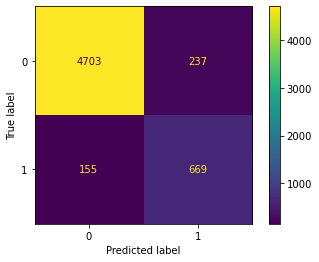

- Accuracy score: 0.9320
- Precision score: 0.7384
- Recall score: 0.8119
- F1 score: 0.7734

SVM results:


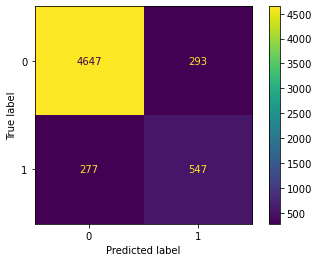

- Accuracy score: 0.9011
- Precision score: 0.6512
- Recall score: 0.6638
- F1 score: 0.6575

Decision Tree results:


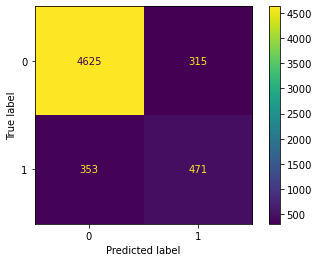

- Accuracy score: 0.8841
- Precision score: 0.5992
- Recall score: 0.5716
- F1 score: 0.5851

Random Forest results:


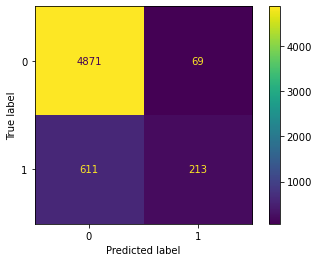

- Accuracy score: 0.8820
- Precision score: 0.7553
- Recall score: 0.2585
- F1 score: 0.3852

Gaussian N-B results:


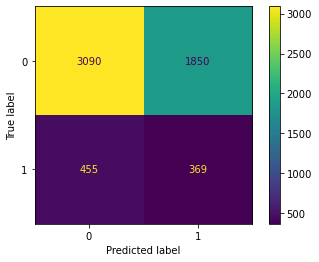

- Accuracy score: 0.6001
- Precision score: 0.1663
- Recall score: 0.4478
- F1 score: 0.2425

Logistic Regression results:


C:\Users\cmore\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



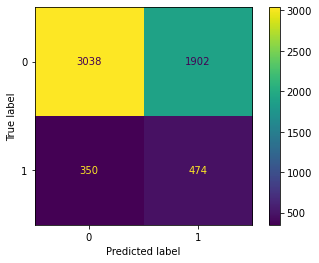

- Accuracy score: 0.6093
- Precision score: 0.1995
- Recall score: 0.5752
- F1 score: 0.2963

Gradient Boosting results:


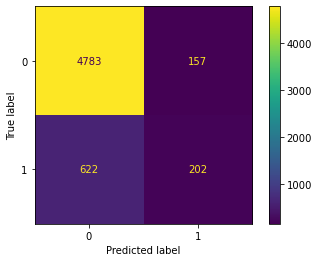

- Accuracy score: 0.8649
- Precision score: 0.5627
- Recall score: 0.2451
- F1 score: 0.3415



In [88]:
for key in models:
    acc, pre, rec, f1 = get_results(key, models[key], X_train_over, X_test, y_train_over, y_test)
    acc_over_res.append(acc)
    pre_over_res.append(pre)
    rec_over_res.append(rec)
    f1_over_res.append(f1)

In [89]:
df_f1_over_comp = pd.DataFrame({'Classifiers':clfs, 'Original dataset':f1_res, 'Oversampled dataset':f1_over_res})
df_f1_over_comp

Classifiers  Original dataset  Oversampled dataset
0                  KNN          0.696804             0.773410
1                  SVM          0.158659             0.657452
2        Decision Tree          0.883918             0.585093
3        Random Forest          0.366603             0.385172
4         Gaussian N-B          0.245964             0.242524
5  Logistic Regression          0.030989             0.296250
6    Gradient Boosting          0.604219             0.341505

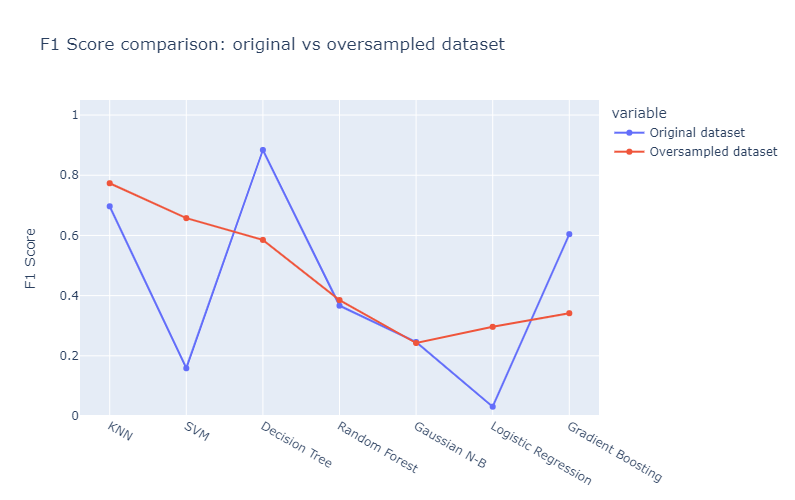

In [90]:
fig = px.line(df_f1_over_comp, x='Classifiers', y=['Original dataset', 'Oversampled dataset'], markers=True,
              title="F1 Score comparison: original vs oversampled dataset",
              height=500,
              range_y=[0,1.05])

fig.update_layout(xaxis_title=None, yaxis_title="F1 Score")

fig.show()

In [91]:
fig.write_image("./images/smote.png", scale=7, width=900, height=500)

Some models benefit from the oversampling and others don't. The conclusion is that we have to improve every model by separate performing a grid search and cross validation. We will have to tune every model to get the best possible result.

## Decision Tree tuning

The decision tree resulted to be the best classifier when trying the algorithms with the default parameters. The default score from the tree was the following:

In [49]:
clf_tree = DecisionTreeClassifier(random_state=42)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree results:


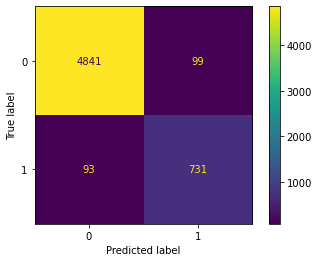

- Accuracy score: 0.9667
- Precision score: 0.8807
- Recall score: 0.8871
- F1 score: 0.8839



In [51]:
acc, pre, rec, f1 = get_results("Decision Tree", clf_tree, X_train, X_test, y_train, y_test)

Let's improve these scores using a Grid Search CV:

The split is stratified on `y`, so we have the same proportion in training and test sets

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

We assign a *balanced* class weight to the decision tree. The weight will penalize the misclassification of class 1 flights:

$$ \frac{n_{samples}}{n_{classes} \cdot \text{np.bincount(y)}} $$

In [53]:
clf_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

Decision Tree results:


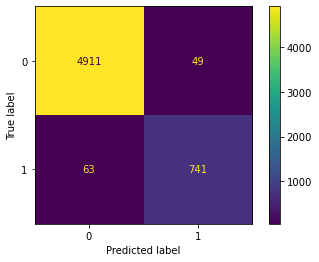

- Accuracy score: 0.9806
- Precision score: 0.9380
- Recall score: 0.9216
- F1 score: 0.9297



In [54]:
acc, pre, rec, f1 = get_results("Decision Tree", clf_tree, X_train, X_test, y_train, y_test)

In [55]:
print('Parameters currently in use:\n')
pprint(clf_tree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}


In [56]:
max_depth = [25, 26, 27, 28, 29, 30, None]
min_samples_split = [4, 5, 6]
min_samples_leaf = [2, 3]
max_features = ['auto', 'sqrt', None]

param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}

pprint(param_grid)

{'max_depth': [25, 26, 27, 28, 29, 30, None],
 'max_features': ['auto', 'sqrt', None],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [4, 5, 6]}


In [57]:
tree_grid = GridSearchCV(estimator = clf_tree,
                         param_grid = param_grid,
                         cv = 5,
                         scoring = ['f1','accuracy','precision','recall'],
                         refit = 'f1',
                         verbose = 3,
                         n_jobs = -1)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [25, 26, 27, 28, 29, 30, None],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 5, 6]},
             refit='f1', scoring=['f1', 'accuracy', 'precision', 'recall'],
             verbose=3)

In [58]:
tree_grid.best_params_

{'max_depth': 25,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [59]:
tree_grid.best_score_

0.9142434213847922

Training results:

In [60]:
print(f"- F1: {tree_grid.cv_results_['mean_test_f1'][np.argmin(tree_grid.cv_results_['rank_test_f1'])]}")
print(f"- Accuracy: {tree_grid.cv_results_['mean_test_accuracy'][np.argmin(tree_grid.cv_results_['rank_test_accuracy'])]}")
print(f"- Precision: {tree_grid.cv_results_['mean_test_precision'][np.argmin(tree_grid.cv_results_['rank_test_precision'])]}")
print(f"- Recall: {tree_grid.cv_results_['mean_test_recall'][np.argmin(tree_grid.cv_results_['rank_test_recall'])]}")

- F1: 0.9142434213847922
- Accuracy: 0.9759694703460695
- Precision: 0.9134890099563446
- Recall: 0.9309704123721299


In [61]:
best_clf_tree = tree_grid.best_estimator_
best_clf_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [62]:
y_pred = best_clf_tree.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Best Decision Tree results:


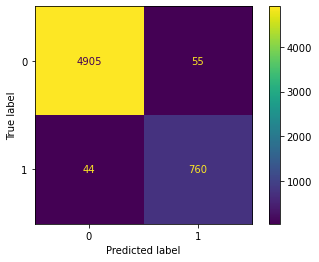

- Accuracy score: 0.9828
- Precision score: 0.9325
- Recall score: 0.9453
- F1 score: 0.9389


In [63]:
print("Best Decision Tree results:")
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
    
# Get the test scores
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"- Accuracy score: {acc:.4f}")
print(f"- Precision score: {pre:.4f}")
print(f"- Recall score: {rec:.4f}")
print(f"- F1 score: {f1:.4f}")

Let's explore the misclassified samples:

In [110]:
misclassifiedIndexes = np.where(y_test!=y_pred)[0]
idxs = X_test.iloc[misclassifiedIndexes].index
df_misclf = df_enc.iloc[idxs]
df_misclf

month  day_of_month  day_of_week  dep_delay  crs_elapsed_time  \
3509      11            11            1         14               400   
24122      1            17            5         13               125   
4312      11            14            4         -1                80   
23308      1            14            2         14               392   
10290     12             3            2         15               265   
...      ...           ...          ...        ...               ...   
17389     12            26            4         -4               263   
27009      1            26            7         12               199   
14092     12            16            1         15               114   
3137      11            10            7         23               140   
14636     12            17            2         12               131   

       distance  crs_dep_m  dep_time_m  crs_arr_m  temperature  dew_point  \
3509       2475       1215        1229       1435           56         54   
24122       427        516         529        641           23          3   
4312        187        550         549        630           37         22   
23308      2475        990        1004       1202           43         40   
10290      1391       1105        1120       1310           34         22   
...         ...        ...         ...        ...          ...        ...   
17389      1521       1305        1301         68           45         41   
27009      1069        990        1002       1189           44         32   
14092       340        440         455        554           34         18   
3137        589       1135        1158       1275           50         35   
14636       483       1205        1217       1336           34         33   

       humidity  wind_speed  wind_gust  pressure  sch_dep  sch_arr  taxi_out  \
3509         93          13          0     29.89       29       43        18   
24122        42          31         38     30.59       48       20        24   
4312         54           5          0     30.46       35       21        10   
23308        89           7          0     30.16       29       29        12   
10290        61          20         26     29.58       36       33        19   
...         ...         ...        ...       ...      ...      ...       ...   
17389        86          12          0     30.38       35       30        27   
27009        63          10          0     29.77       30       31        15   
14092        52           8          0     30.26       38       32        14   
3137         57           9          0     30.03       41       28         9   
14636        96           8          0     29.70       28       41        29   

       is_delay  op_unique_carrier_9E  op_unique_carrier_AA  \
3509          0                     0                     0   
24122         0                     0                     0   
4312          0                     1                     0   
23308         0                     0                     0   
10290         1                     0                     0   
...         ...                   ...                   ...   
17389         0                     0                     1   
27009         0                     0                     0   
14092         1                     1                     0   
3137          1                     1                     0   
14636         0                     0                     0   

       op_unique_carrier_AS  op_unique_carrier_B6  op_unique_carrier_DL  \
3509                      1                     0                     0   
24122                     0                     0                     1   
4312                      0                     0                     0   
23308                     0                     1                     0   
10290                     0                     0                     1   
...                     ...                   ...

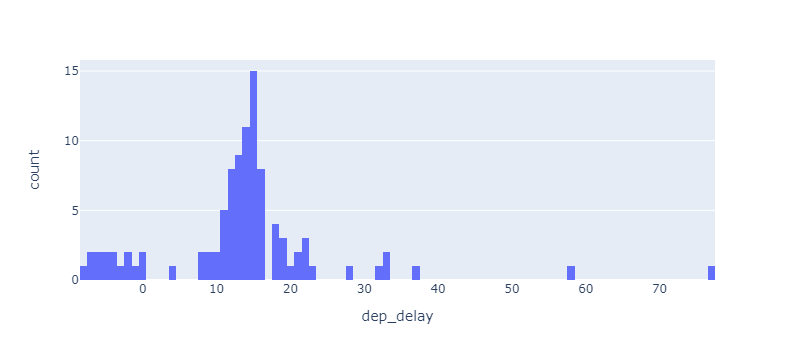

In [111]:
fig = px.histogram(df_misclf, x='dep_delay', nbins=100)
fig.show()

In [112]:
# fig.write_image("./images/misclassified.png", scale=7, width=900, height=500)

As expected, most of the misclassified flights have a departure delay close to 15 min, the cut-off threshold between delayed and non-delayed flights (0 and 1 classes).